### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


### Reading the data files
Note: Please change file path accordingly

In [ ]:
train_reviews_df = pd.read_csv("d/RIT Challenge/rit-business-analytics-competition-spring-2023/train_reviews.csv")
train_reviews_df.head()

,review_title,review_body,review_date,review_rating,number_of_photos,helpful_vote,reviewer_ID,fake_asin,fake_review,product_ID,review_ID
0,Super product,"My husband has a hard time sleeping, the very ...",2020-04-13,5,0,0,380263,1,1,389,34510
1,Very sturdy,Rving,2020-08-29,5,0,0,845137,0,0,99,381688
2,Five Stars,has dramatically improved my toe nail appearances,2018-02-27,5,0,0,659759,0,0,107,417933
3,Great portable irrigator,I recently got braces and needed this for work...,2012-05-16,5,0,1,73493,0,0,66,166465
4,Four Stars,The Salad Shooter works great and saves time.,2015-01-05,4,0,0,714841,0,0,14,289006


In [ ]:
rank_data_df = pd.read_csv("/mnt/d/ISB AMPBA17/RIT Challenge/rit-business-analytics-competition-spring-2023/rank_data.csv")
rank_data_df.head()

,rank,date,product_ID
0,136649,2019-06-18,0
1,62611,2019-06-19,0
2,119165,2019-06-20,0
3,106195,2019-06-22,0
4,189943,2019-06-24,0


In [ ]:
price_data_df = pd.read_csv("/mnt/d/ISB AMPBA17/RIT Challenge/rit-business-analytics-competition-spring-2023/price_data.csv")
price_data_df.head()

,price,date,product_ID
0,899,2019-06-18,0
1,839,2019-07-13,0
2,824,2019-07-16,0
3,892,2019-07-19,0
4,899,2019-07-21,0


## Understanding the data

### Data Dictionary

- review_ID: Unique ID of the review
- review_title: Title of the review
- review_body: Actual review text
- review_date: The date the review is posted
- review_rating: Rating of the review [1, 2, 3, 4, 5]
- number_of_photos: Number of photos attached to the review by the reviewer
- helpful_vote: Number of users found the review helpful
- reviewed_ID: Unique ID of the reviewer
- fake_asin: Whether or not the product ever collected fake reviews
- fake_review: Whether or not the review is marked as fake by the platform
- product_ID: Unique ID of the product
- review_ID: Unique ID of the review

In [ ]:
train_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392760 entries, 0 to 392759
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   review_title      392403 non-null  object
 1   review_body       392716 non-null  object
 2   review_date       392760 non-null  object
 3   review_rating     392760 non-null  int64 
 4   number_of_photos  392760 non-null  int64 
 5   helpful_vote      392760 non-null  int64 
 6   reviewer_ID       392760 non-null  int64 
 7   fake_asin         392760 non-null  int64 
 8   fake_review       392760 non-null  int64 
 9   product_ID        392760 non-null  int64 
 10  review_ID         392760 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 33.0+ MB


#### How many reviews?

In [ ]:
print("Reviews:",train_reviews_df.shape[0])

Reviews: 392760


#### How many features?

In [ ]:
print("Features:",train_reviews_df.shape[1])

Features: 11


## Exploratory Data Analysis

Now that we have understood the data, we will explore all the features present so it may present us better insights as to what can be done and if any feature can/should be engineered.

### 1. Reviewer_ID

#### How many unique reviewers?

In [ ]:
print("Reviewers:",train_reviews_df.reviewer_ID.nunique())

Reviewers: 383695


#### How many reviewers with more than one review?

In [ ]:
review_count = train_reviews_df.reviewer_ID.value_counts()

print(review_count.loc[lambda x : x>1])

254332     12
1028117    11
1172015     8
669820      8
327136      8
           ..
102482      2
464412      2
875239      2
1233672     2
121672      2
Name: reviewer_ID, Length: 8306, dtype: int64


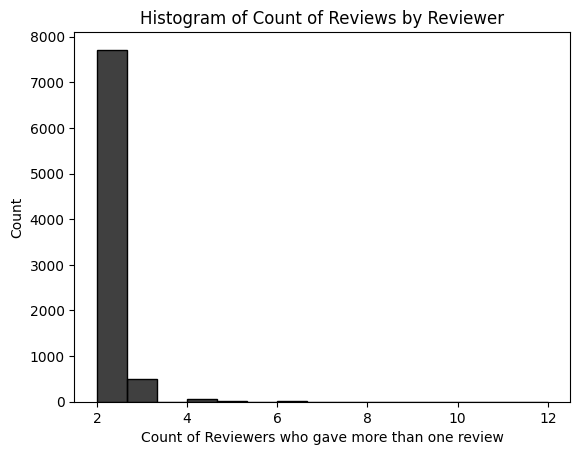

In [ ]:
sns.histplot(review_count.loc[lambda x : x>1], color='black')
plt.xlabel('Count of Reviewers who gave more than one review')
plt.title('Histogram of Count of Reviews by Reviewer');

### 2. Review Date

#### Trend of frequency of reviews

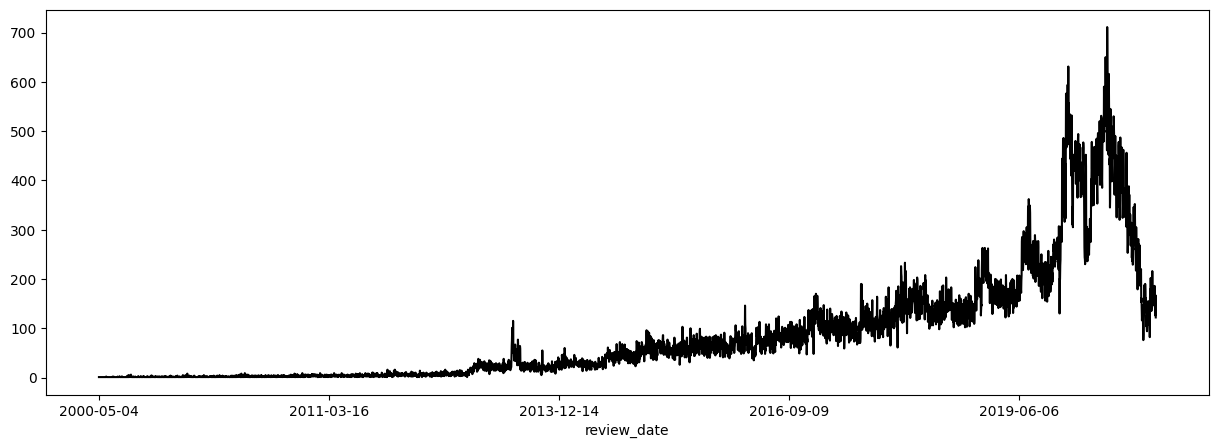

In [ ]:
plt.figure(figsize=(15,5))
train_reviews_df.groupby('review_date').size().plot(color='black');

In [ ]:
rating_trend = train_reviews_df.groupby(['review_date','fake_review']).size().unstack().fillna(0)
rating_trend.columns = ['Not Fake','Fake']
rating_trend.head()

,Not Fake,Fake
review_date,,
2000-05-04,1.0,0.0
2000-05-14,1.0,0.0
2000-06-12,1.0,0.0
2000-07-13,1.0,0.0
2001-01-15,1.0,0.0


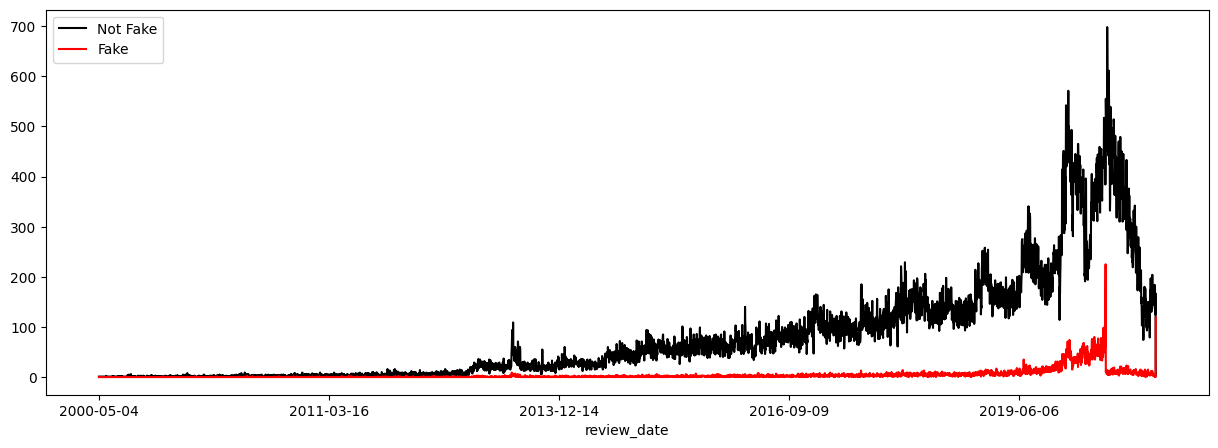

In [ ]:
plt.figure(figsize=(15,5))
rating_trend['Not Fake'].plot(color='black', label = 'Not Fake')
rating_trend['Fake'].plot(color='red', label = 'Fake')
plt.legend();

For whatever reason, the fake reviews have stopped after a certain date.  
Let's identify that date.

We see there is considerable amount of noise in the data, mostly due to the granularity.  
We will group it by year-month to remove the noise. 

### 3. Review Rating

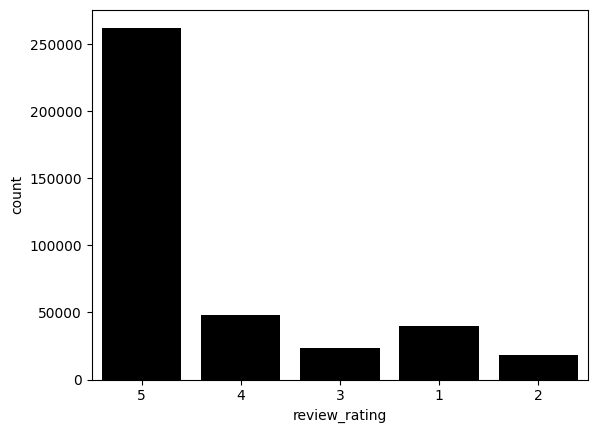

In [ ]:
sns.countplot(data=train_reviews_df, x=train_reviews_df.review_rating.astype('str'), color='black');

Insights:
- Large number of reviews are highly rated (5 stars)
- Ideally, any data should follow normal distribution
- This is a clear indication that rating 5 may have several fake reviews

Let's confirm this hypothesis using heatmap of review rating and fake review tag

In [ ]:
review_rating_fake = train_reviews_df.groupby(['review_rating','fake_review']).size().unstack()

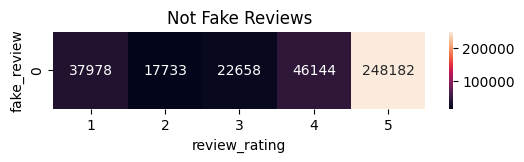

In [ ]:
plt.figure(figsize=(6,1))
sns.heatmap(review_rating_fake[[0]].T, annot=True, fmt='d')
plt.title('Not Fake Reviews');

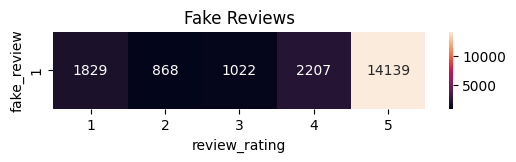

In [ ]:
plt.figure(figsize=(6,1))
sns.heatmap(review_rating_fake[[1]].T, annot=True, fmt='d')
plt.title('Fake Reviews');

In [ ]:
review_rating_fake_perc = review_rating_fake.div(review_rating_fake.sum(axis=0))
review_rating_fake_perc

fake_review,0,1
review_rating,,
1,0.101901,0.091154
2,0.047580,0.043259
3,0.060795,0.050934
4,0.123812,0.109993
5,0.665912,0.704660


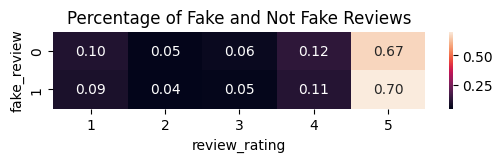

In [ ]:
plt.figure(figsize=(6,1))
sns.heatmap(review_rating_fake_perc.T, annot=True, fmt='.2f')
plt.title('Percentage of Fake and Not Fake Reviews');

How to read the above chart - 
- The above chart shows the distribution of reviews across the ratings
- The sum of each row becomes 1 (i.e., 100%)
- 0.10 at review_rating = 1 where fake_review = 0, implies that 10% of not fake reviews are in rating 1
- 0.09 at review_rating = 1 where fake_review = 1, implies that 9% of fake reviews are in rating 1

Insights
- From this chart we see that fake reviews are equally distributed across the ratings
- The hypothesis - some ratings may have more fake review while some may have less fake reviews

### 4. Number of photos

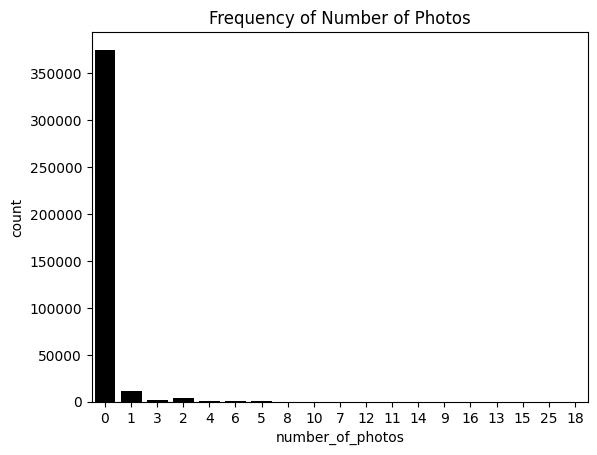

In [ ]:
sns.countplot(data=train_reviews_df, x=train_reviews_df.number_of_photos.astype('str'), color='black')
plt.title('Frequency of Number of Photos');

### 4. Helpful Vote

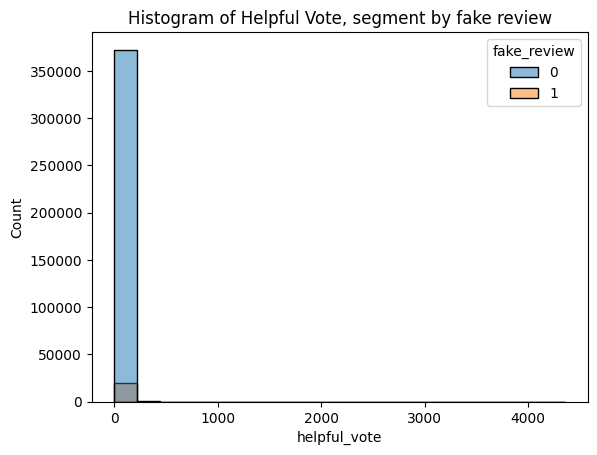

In [ ]:
sns.histplot(data=train_reviews_df, x='helpful_vote', hue='fake_review')
plt.title('Histogram of Helpful Vote, segment by fake review');

### 5. fake_asin

In [ ]:
fake_asin_group = train_reviews_df.groupby(['fake_asin','fake_review']).size().unstack()
fake_asin_group

fake_review,0,1
fake_asin,,
0,326867,10398
1,45828,9667


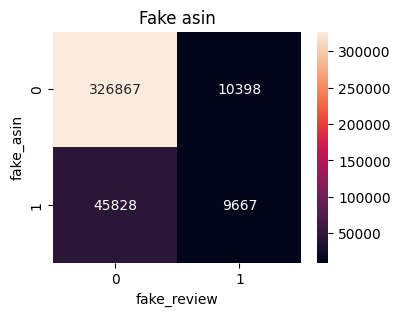

In [ ]:
plt.figure(figsize=(4,3))
sns.heatmap(fake_asin_group, annot=True, fmt='d')
plt.title('Fake asin');

## Feature Engineering

### Replace reviewer_id with the number of reviews he made

In [ ]:
review_count_dict = review_count.to_dict()

In [ ]:
train_reviews_df['review_count'] = train_reviews_df['reviewer_ID'].map(review_count_dict)

In [ ]:
train_reviews_df.head()

,review_title,review_body,review_date,review_rating,number_of_photos,helpful_vote,reviewer_ID,fake_asin,fake_review,product_ID,review_ID,review_count
0,Super product,"My husband has a hard time sleeping, the very ...",2020-04-13,5,0,0,380263,1,1,389,34510,1
1,Very sturdy,Rving,2020-08-29,5,0,0,845137,0,0,99,381688,1
2,Five Stars,has dramatically improved my toe nail appearances,2018-02-27,5,0,0,659759,0,0,107,417933,1
3,Great portable irrigator,I recently got braces and needed this for work...,2012-05-16,5,0,1,73493,0,0,66,166465,1
4,Four Stars,The Salad Shooter works great and saves time.,2015-01-05,4,0,0,714841,0,0,14,289006,1


In [ ]:
train_reviews_df

,review_title,review_body,review_date,review_rating,number_of_photos,helpful_vote,reviewer_ID,fake_asin,fake_review,product_ID,review_ID,review_count
0,Super product,"My husband has a hard time sleeping, the very ...",2020-04-13,5,0,0,380263,1,1,389,34510,1
1,Very sturdy,Rving,2020-08-29,5,0,0,845137,0,0,99,381688,1
2,Five Stars,has dramatically improved my toe nail appearances,2018-02-27,5,0,0,659759,0,0,107,417933,1
3,Great portable irrigator,I recently got braces and needed this for work...,2012-05-16,5,0,1,73493,0,0,66,166465,1
4,Four Stars,The Salad Shooter works great and saves time.,2015-01-05,4,0,0,714841,0,0,14,289006,1
...,...,...,...,...,...,...,...,...,...,...,...,...
392755,Functional,"Smaller than I realized, but big enough for a ...",2020-03-24,5,0,1,456104,1,0,387,258349,1
392756,Great price!,Very useful!,2019-01-20,5,0,0,27488,0,0,107,365517,1
392757,but I love this thing,"So weird, but I love this thing. No more searc...",2018-06-20,5,0,0,1105613,1,0,263,130505,1
392758,waste of money!,this lasted less than 6 months.,2019-11-14,1,0,0,443653,0,0,212,145519,1


#### Extracting year from date to get lower granularity and reduce noice

In [ ]:
train_reviews_df['year'] = train_reviews_df['review_date'].str.split('-').str[0].astype('int')

#### Getting the sentiment score of the reviews using vader library
Hypothesis:
- If a person is taked to give a fake review, it is understandably to bolster or tarnish the image of that product
- This means, the review may be too positive or too negative

In [ ]:
sentAnalyzer = SentimentIntensityAnalyzer()

In [ ]:
x = 'Super product'
sentAnalyzer.polarity_scores(x)

{'neg': 0.0, 'neu': 0.204, 'pos': 0.796, 'compound': 0.5994}

In [ ]:
def compound_sent_analyzer(x):
    try:
        return sentAnalyzer.polarity_scores(x)['compound']
    except:
        return 0

def pos_sent_analyzer(x):
    try:
        return sentAnalyzer.polarity_scores(x)['pos']
    except:
        return 0

def neg_sent_analyzer(x):
    try:
        return sentAnalyzer.polarity_scores(x)['neg']
    except:
        return 0

In [ ]:
train_reviews_df['body_senti_comp'] = train_reviews_df['review_body'].apply(lambda x : compound_sent_analyzer(x))
train_reviews_df['body_senti_pos'] = train_reviews_df['review_body'].apply(lambda x : pos_sent_analyzer(x))
train_reviews_df['body_senti_neg'] = train_reviews_df['review_body'].apply(lambda x : neg_sent_analyzer(x))
train_reviews_df['title_senti_comp'] = train_reviews_df['review_title'].apply(lambda x : compound_sent_analyzer(x))
train_reviews_df['title_senti_pos'] = train_reviews_df['review_title'].apply(lambda x : pos_sent_analyzer(x))
train_reviews_df['title_senti_neg'] = train_reviews_df['review_title'].apply(lambda x : neg_sent_analyzer(x))

In [ ]:
def text_length(x):
    try:
        return len(x)
    except:
        return 0

In [ ]:
train_reviews_df['review_length'] = train_reviews_df['review_body'].map(lambda x: text_length(x))

## Machine Learning - Preprocessing

#### Removing redundant columns

In [ ]:
train_reviews_df = train_reviews_df.drop(['review_title','review_body','review_date','reviewer_ID','product_ID','review_ID'],axis=1)


#### Train test split

In [ ]:
y = train_reviews_df.fake_review
X = train_reviews_df.drop('fake_review',axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(235656, 13) (157104, 13) (235656,) (157104,)


#### Standard Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Machine Learning - Modelling and Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
def algo(algorithm):
    model = algorithm()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print('The accuracy of {} model is {}'.format(model, accuracy_score(y_test, preds).round(2)))
    print("\n")
    print("CLASSIFICATION REPORT",'\n',classification_report(y_test, preds),"\n")
    print("CONFUSION MATRIX",'\n')
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True,fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

### Decision Tree

The accuracy of DecisionTreeClassifier() model is 0.9


CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.95      0.95      0.95    149021
           1       0.11      0.12      0.11      8083

    accuracy                           0.90    157104
   macro avg       0.53      0.53      0.53    157104
weighted avg       0.91      0.90      0.91    157104
 

CONFUSION MATRIX 



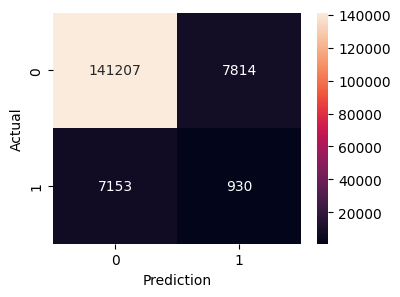

In [ ]:
from sklearn.tree import DecisionTreeClassifier
algo(DecisionTreeClassifier)

### Random Forest Classfier

The accuracy of RandomForestClassifier() model is 0.95


CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.95      1.00      0.97    149021
           1       0.18      0.01      0.02      8083

    accuracy                           0.95    157104
   macro avg       0.57      0.50      0.50    157104
weighted avg       0.91      0.95      0.92    157104
 

CONFUSION MATRIX 



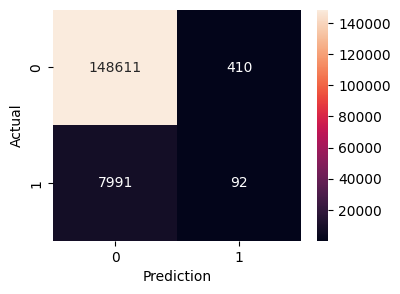

In [ ]:
from sklearn.ensemble import RandomForestClassifier
algo(RandomForestClassifier)

### K-Nearest Neighbor

The accuracy of KNeighborsClassifier() model is 0.94


CLASSIFICATION REPORT 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97    149021
           1       0.21      0.03      0.05      8083

    accuracy                           0.94    157104
   macro avg       0.58      0.51      0.51    157104
weighted avg       0.91      0.94      0.92    157104
 

CONFUSION MATRIX 



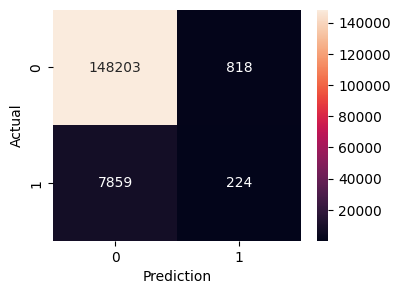

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
algo(KNeighborsClassifier)

From the above 3 models, the best performing is Random Forest Classification algorithm with a 95% accuracy.

## END